목표
- A구, B구, C구의 승용차 이용률 평균이 서로 차이가 있는지 검정
- 사후 검정(Tukey’s HSD Test)을 수행하여 어떤 그룹 간 차이가 유의미한지 분석

In [ ]:
!pip install statsmodels

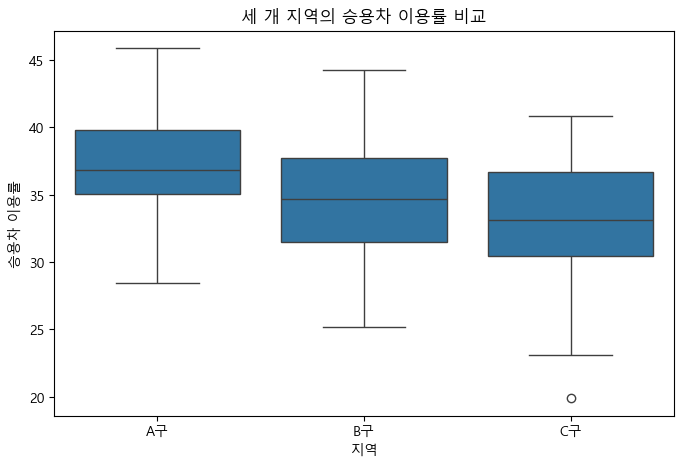

In [5]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'


# 랜덤 시드 설정
np.random.seed(42)

# 세 개 지역(A, B, C)의 승용차 이용률 데이터 생성
commute_A = np.random.normal(loc=38, scale=5, size=30)  # A구 (평균 38%)
commute_B = np.random.normal(loc=35, scale=5, size=30)  # B구 (평균 35%)
commute_C = np.random.normal(loc=33, scale=5, size=30)  # C구 (평균 33%)

# 데이터 결합
df = pd.DataFrame({
    '승용차 이용률': np.concatenate([commute_A, commute_B, commute_C]),
    '지역': ['A구']*30 + ['B구']*30 + ['C구']*30
})

# 박스플롯 시각화
plt.figure(figsize=(8, 5))
sns.boxplot(x='지역', y='승용차 이용률', data=df)
plt.title("세 개 지역의 승용차 이용률 비교")
plt.show()


In [6]:
# 각 지역별 정규성 검정 수행
shapiro_A = stats.shapiro(commute_A)
shapiro_B = stats.shapiro(commute_B)
shapiro_C = stats.shapiro(commute_C)

print(f"Shapiro-Wilk test (A구): p-value = {shapiro_A.pvalue:.4f}")
print(f"Shapiro-Wilk test (B구): p-value = {shapiro_B.pvalue:.4f}")
print(f"Shapiro-Wilk test (C구): p-value = {shapiro_C.pvalue:.4f}")

if shapiro_A.pvalue > 0.05 and shapiro_B.pvalue > 0.05 and shapiro_C.pvalue > 0.05:
    print("모든 그룹이 정규성을 만족함")
else:
    print("정규성이 만족되지 않음, 비모수 검정 필요")


Shapiro-Wilk test (A구): p-value = 0.6868
Shapiro-Wilk test (B구): p-value = 0.9130
Shapiro-Wilk test (C구): p-value = 0.3654
모든 그룹이 정규성을 만족함


In [7]:
# Levene’s 등분산 검정 수행
levene_test = stats.levene(commute_A, commute_B, commute_C)

print(f"Levene’s 등분산 검정 결과: W-statistic = {levene_test.statistic:.4f}, p-value = {levene_test.pvalue:.4f}")

if levene_test.pvalue > 0.05:
    print("세 그룹의 분산이 동일함 (등분산 가정 가능)")
else:
    print("세 그룹의 분산이 다름 (이분산 가정 필요)")


Levene’s 등분산 검정 결과: W-statistic = 0.1480, p-value = 0.8627
세 그룹의 분산이 동일함 (등분산 가정 가능)


In [8]:
# 컬럼명을 영어로 변경
df.rename(columns={'승용차 이용률': 'car_usage', '지역': 'region'}, inplace=True)

# One-Way ANOVA 수행
anova_result = smf.ols('car_usage ~ C(region)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_result, typ=2)

# 결과 출력
print(anova_table)

                sum_sq    df         F    PR(>F)
C(region)   248.296717   2.0  5.598587  0.005162
Residual   1929.220089  87.0       NaN       NaN


In [9]:
# 성별 데이터 추가 (각 지역당 남녀 15명씩)
gender = ['남']*15 + ['여']*15
gender_all = gender * 3  # 총 90명 (30명 × 3지역)

# 기존 df에 추가
df['gender'] = gender_all

In [11]:
# Two-Way ANOVA 모델: 지역(region)과 성별(gender)의 주효과 + 상호작용 효과
model = smf.ols('car_usage ~ C(region) + C(gender) + C(region):C(gender)', data=df).fit()
anova_table2 = sm.stats.anova_lm(model, typ=2)
print(anova_table2)

"""
C(region)	지역에 따라 평균 차이가 있는지
C(gender)	성별에 따라 평균 차이가 있는지
C(region):C(gender)	지역과 성별 간의 상호작용 효과가 있는지
"""

                          sum_sq    df         F    PR(>F)
C(region)             248.296717   2.0  5.541784  0.005487
C(gender)               1.528877   1.0  0.068247  0.794546
C(region):C(gender)    45.903396   2.0  1.024527  0.363407
Residual             1881.787816  84.0       NaN       NaN


'\nC(region)\t지역에 따라 평균 차이가 있는지\nC(gender)\t성별에 따라 평균 차이가 있는지\nC(region):C(gender)\t지역과 성별 간의 상호작용 효과가 있는지\n'